In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
import scipy
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
from sklearn.model_selection import cross_validate
from sklearn.base import clone as sklearn_clone
from sklearn.model_selection import KFold

from tqdm import tqdm
tqdm.pandas()

import random

import sys
sys.path.append('..')

from helpers.model import (
    balance_data
)

## Load data

In [2]:
df_styl = pd.read_parquet('../datasets/used_data/02_classical_ml/03_01_statements_styllometric_features.parquet')
df_pos = pd.read_parquet('../datasets/used_data/02_classical_ml/03_02_statements_POS_ngrams.parquet')
df_ngram = pd.read_parquet('../datasets/used_data/02_classical_ml/03_03_statements_words_ngrams.parquet')

with open('../datasets/used_data/02_classical_ml/03_04_statements_herbert.npy', 'rb') as f:
    df_herbert = pd.DataFrame(np.load(f))

with open('../datasets/used_data/02_classical_ml/03_05_statements_roberta.npy', 'rb') as f:
    df_roberta = pd.DataFrame(np.load(f))

In [3]:
print(df_styl.shape, df_pos.shape, df_ngram.shape, df_herbert.shape)

(6529, 30) (6529, 2647) (6529, 2771) (6529, 1024)


In [4]:
y_train = df_styl['assestment']

In [5]:
y_train.value_counts()

assestment
1    3434
0    3095
Name: count, dtype: int64

In [6]:
df_styl.pop('assestment');
df_pos.pop('assestment');
df_ngram.pop('assestment');

## Make balanced datasets

In [7]:
X_train_u = df_styl
X_pos_u = df_pos 
X_ngram_u = df_ngram
X_herbert_u = df_herbert
X_roberta_u = df_roberta

y_train_u = y_train 

In [8]:
words = X_ngram_u['TEXT_WORD'].str.split(' ').values
X_ngram_u.pop('TEXT_WORD');

## CV creation
### LDA

In [9]:
ideal_topic_num = 10

In [10]:
dictionary = gensim.corpora.Dictionary(words)

bow_corpus = [dictionary.doc2bow(doc) for doc in words]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(words):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

# X_train_u['topic'] = topics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6529/6529 [00:01<00:00, 5802.53it/s]


In [11]:
x = lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.033*"europejski" + 0.021*"unia" + 0.014*"komisja" + 0.011*"sprawa" + 0.010*"europa"
1 0.021*"prawo" + 0.014*"trybunał" + 0.013*"ustawa" + 0.013*"konstytucja" + 0.013*"polski"
2 0.016*"procent" + 0.013*"minister" + 0.009*"polak" + 0.008*"bezrobocie" + 0.007*"europejski"
3 0.018*"państwo" + 0.015*"kraj" + 0.015*"budżet" + 0.013*"prezydent" + 0.012*"europejski"
4 0.016*"wybory" + 0.014*"osoba" + 0.012*"rząd" + 0.010*"poseł" + 0.010*"sejm"
5 0.017*"sędzia" + 0.012*"sąd" + 0.010*"trybunał" + 0.009*"konstytucyjny" + 0.008*"duży"
6 0.013*"mówić" + 0.013*"miejsce" + 0.010*"osoba" + 0.009*"polak" + 0.009*"program"
7 0.021*"procent" + 0.021*"pkb" + 0.016*"wzrost" + 0.013*"poziom" + 0.011*"wzrosnąć"
8 0.038*"dziecko" + 0.024*"złoty" + 0.012*"warszawa" + 0.012*"chodzić" + 0.012*"miasto"
9 0.021*"człowiek" + 0.013*"osoba" + 0.012*"kraj" + 0.008*"europejski" + 0.008*"mówić"


In [12]:
y_train_u_topics = pd.DataFrame(y_train_u.copy())
y_train_u_topics['topic'] = topics
y_train_u_topics['n'] = 1
y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')

assestment,0,1
topic,,
0,255,335
1,345,560
2,355,268
3,341,311
4,293,330
5,241,307
6,284,372
7,347,285
8,353,315


In [13]:
df_plot = y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')
# df_plot[1] = -df_plot[1]

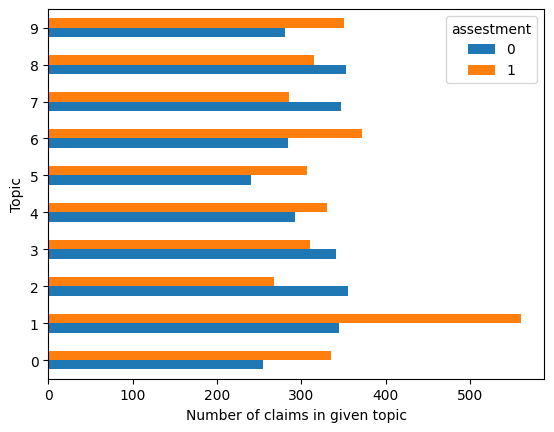

In [14]:
# Transpose the DataFrame
# df_plot = df_plot.transpose()

# Plotting bidirectional bar plot
fig, ax = plt.subplots()
df_plot.plot(kind='barh', stacked=False, ax=ax)

# Adjusting labels and legend
ax.set_ylabel('Topic')
ax.set_xlabel('Number of claims in given topic')
# ax.set_title('Bidirectional Bar Plot')
# ax.legend(title='Assessment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [15]:
# with open('../datasets/used_data/03_bert_like_models/02_topics.npy', 'wb') as f:
#     np.save(f, np.array(topics))

### Kfold

In [16]:
cv_fold = []
cv_fold_i = []

for i in y_train_u_topics['topic'].unique().reshape(10,-1):
    train_cv = X_train_u.index[ ~np.isin(y_train_u_topics["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(y_train_u_topics["topic"], i) ].values
    
    # train_cv_i = X_train_u.reset_index().index[ ~np.isin(X_train_u["topic"], i) ].values
    # test_cv_i = X_train_u.reset_index().index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    # cv_fold_i.append( [train_cv_i, test_cv_i])

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=111)
kf.get_n_splits(X_train_u)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(X_train_u):
    train_cv = X_train_u.iloc[ train_index, : ].index.values
    test_cv = X_train_u.iloc[ test_index, : ].index.values

    # train_cv_i= X_train_u.reset_index().iloc[ train_index, : ].index.values
    # test_cv_i = X_train_u.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    # cv_Kfold_i.append( [train_cv_i, test_cv_i])

In [19]:
# with open("../datasets/used_data/cv_fold.txt", 'w') as fp:
#     json.dump(cv_fold, fp)

## Run experiments

In [20]:
def run_experiment(X, y, cv, clf_org, r_min=0.05):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : [],
        'col_keep' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
        
        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]

        # keep only columns with corr > 0.05
        if r_min:
            col_keep = []
            for c in X_train_t.columns:
                min_v =X_train_t[c].values.min()
                max_v = X_train_t[c].values.max()
    
                if min_v < max_v:
                    r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                    if ~np.isnan(r) and r > r_min:
                        col_keep.append(c)
            
            if len(col_keep) == 0:
                print('No values returned')
        
            X_train_t = X_train_t[col_keep]
        else:
            col_keep =  X_train_t.columns.values.tolist()


        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]
        
        if r_min:
            X_test_t = X_test_t[col_keep]

        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)

        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        results['col_keep'].append( len(col_keep)) 
    
    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
        "Precision": np.array(results['test_precision']).mean(),
        "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        "Cols used": np.array(results['col_keep']),
        }

#     print(c_matrix)

    return metrics

## Topics Kfold

In [21]:
random.seed(111)

In [22]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
clf_rf = RandomForestClassifier(random_state=111, max_depth=5)

In [23]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, #clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', #'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
        # [X_ngram_u, X_train_u, X_pos_u, X_herbert_u],
        # ['ngrams  ', 'features', 'pos     ', 'herbert '],
        # [0.01, None, 0.01, None]
        [X_ngram_u, 
         X_ngram_u, 
         # X_ngram_u, 
         # X_ngram_u, 
         X_train_u, 
         X_pos_u, 
         X_pos_u, 
         # X_pos_u, 
         # X_pos_u, 
         ],
        ['ngrams  None', 
         # 'ngrams  0.01', 
         'ngrams  0.03', 
         # 'ngrams  0.05', 
         'features    ', 
         'pos     None', 
         # 'pos     0.01', 
         'pos     0.03', 
         # 'pos     0.05', 
        ],
        [None, 
         # 0.01, 
         0.03,
         # 0.05, 
         None, 
         None, 
         # 0.01, 
         0.03, 
         # 0.05, 
         ]
    ):
        out = run_experiment(X_used, y_train_u, cv_fold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean().round(0):.0f}+-{out["Cols used"].std().round(0):.0f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.62+-0.02 F1 Score 0.67+-0.06 Cols used 2769+-0
ngrams  0.03 lr C1 Accuracy 0.60+-0.02 F1 Score 0.62+-0.06 Cols used 162+-6
features     lr C1 Accuracy 0.55+-0.03 F1 Score 0.62+-0.04 Cols used 29+-0
pos     None lr C1 Accuracy 0.54+-0.03 F1 Score 0.60+-0.04 Cols used 2646+-0
pos     0.03 lr C1 Accuracy 0.53+-0.02 F1 Score 0.59+-0.04 Cols used 70+-6



## Random Kfold

In [24]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, # clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', # 'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
        [X_ngram_u, 
         X_ngram_u, 
         # X_ngram_u, 
         # X_ngram_u, 
         X_train_u, 
         X_pos_u, 
         X_pos_u, 
         # X_pos_u, 
         # X_pos_u, 
         ],
        ['ngrams  None', 
         # 'ngrams  0.01', 
         'ngrams  0.03', 
         # 'ngrams  0.05', 
         'features    ', 
         'pos     None', 
         # 'pos     0.01', 
         'pos     0.03', 
         # 'pos     0.05', 
        ],
        [None, 
         # 0.01, 
         0.03,
         # 0.05, 
         None, 
         None, 
         # 0.01, 
         0.03, 
         # 0.05, 
         ]
    ):
        out = run_experiment(X_used, y_train_u, cv_Kfold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean().round(0):.0f}+-{out["Cols used"].std().round(0):.0f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.63+-0.02 F1 Score 0.68+-0.02 Cols used 2769+-0
ngrams  0.03 lr C1 Accuracy 0.60+-0.02 F1 Score 0.63+-0.02 Cols used 161+-9
features     lr C1 Accuracy 0.56+-0.02 F1 Score 0.63+-0.02 Cols used 29+-0
pos     None lr C1 Accuracy 0.54+-0.01 F1 Score 0.61+-0.01 Cols used 2646+-0
pos     0.03 lr C1 Accuracy 0.54+-0.01 F1 Score 0.60+-0.02 Cols used 73+-6



## XAI

### Agg

In [56]:
cv = cv_Kfold  
X = X_ngram_u
y = y_train_u
r_min = 0.03 

imp = []

for train_cv, test_cv in tqdm(cv):
    clf = sklearn_clone(clf_lr_1)
    
    X_train_t = X[X.index.isin(train_cv)]
    y_train_t = y[y.index.isin(train_cv)]

    # keep only columns with corr > 0.05
    if r_min:
        col_keep = []
        for c in X_train_t.columns:
            min_v =X_train_t[c].values.min()
            max_v = X_train_t[c].values.max()

            if min_v < max_v:
                r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                if ~np.isnan(r) and r > r_min:
                    col_keep.append(c)
        
        if len(col_keep) == 0:
            print('No values returned')
    
        X_train_t = X_train_t[col_keep]
    else:
        col_keep =  X_train_t.columns.values.tolist()


    X_test_t = X[X.index.isin(test_cv)]
    y_test_t = y[y.index.isin(test_cv)]
    
    if r_min:
        X_test_t = X_test_t[col_keep]

    clf.fit(X_train_t, y_train_t)

    y_pred = clf.predict(X_test_t)
    
    coefficients = clf.coef_[0]
    imp.append({col_keep[i]: coefficients[i] for i in range(len(col_keep))})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


In [58]:
df_imp = pd.DataFrame(imp)

In [59]:
df_imp.shape

(10, 286)

In [73]:
df_imp.loc[ :, df_imp.notna().sum() == 1]

,wolność,wiedza,szkoda,sklep,wino,podwójny,wysiłek,środkowy,rodzaj,dzięki,...,media publiczny,walka,handel,chrześcijański,swoboda,stan,powód,olbrzymi,dopuszczać,poradzić
0,0.812422,0.481063,0.562142,0.422788,0.302558,0.264923,0.333691,0.201444,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.715756,0.880987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.345357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.695817,0.640148,0.492264,0.317685,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.218167,0.839667,0.430036,0.297405,0.302983


In [74]:
df_imp.loc[ :, df_imp.notna().sum() == 10]

,prawo,człowiek,chcieć,sędzia,móc,władza,strona,polityka,wiedzieć,polityczny,...,elita,widz,bić,wizja,czyn,komisja europejski,wymiar sprawiedliwość,puszczać białowieski,większość parlamentarny,trybunał sprawiedliwość
0,2.253462,1.197414,1.867369,1.409156,1.690625,1.365179,1.167953,0.909836,1.516921,1.168873,...,0.269766,1.272461,1.251635,0.704767,1.933548,0.867741,0.593820,0.428195,0.340647,0.344886
1,2.016170,1.115983,2.160322,1.613345,1.499016,1.136800,0.993076,1.298977,1.526211,1.188712,...,0.260437,1.314346,1.326978,0.773066,1.612178,0.971238,0.690369,0.472487,0.342916,0.304017
2,2.076536,1.132917,2.193289,1.559256,1.645693,1.228836,1.299393,1.153183,1.432592,1.265293,...,0.264759,1.111586,1.121597,0.830593,2.017025,0.916491,0.794350,0.406934,0.315390,0.307606
3,2.187157,1.128933,1.904590,1.405387,1.764866,1.142098,1.323613,1.266193,1.444064,1.303130,...,0.288251,1.316702,1.068350,0.617327,1.770220,1.062317,0.729599,0.489377,0.305346,0.373521
4,1.947331,1.035833,2.215438,1.312292,1.577328,0.945842,1.077641,1.255479,1.919601,1.399641,...,0.257317,1.523159,1.282533,0.641318,1.862819,1.013743,0.757560,0.335393,0.342496,0.354311
5,1.996378,1.125737,1.980032,1.413024,1.597007,0.902896,1.239230,1.276131,1.172722,1.380186,...,0.293838,1.228967,1.252611,0.709910,2.086323,0.869704,0.731253,0.425909,0.253131,0.371373
6,2.052967,1.022027,2.237600,1.229258,1.911428,1.118328,1.167489,1.220242,1.276058,1.309019,...,0.292001,1.412090,1.437931,0.648118,1.869926,0.855497,0.707682,0.458002,0.219393,0.330449
7,2.017594,1.154998,1.964900,1.789792,1.603108,1.125208,1.297843,1.353976,1.348181,1.054127,...,0.218859,1.281099,1.446196,0.862072,1.938236,0.877728,0.611940,0.376909,0.325724,0.324352
8,1.832731,1.087674,2.103566,1.154080,1.710795,1.311927,1.164877,1.293918,1.506087,1.290934,...,0.253520,1.201084,1.297652,0.695910,1.848720,1.054314,0.782367,0.388190,0.284725,0.359972
9,1.883553,1.095723,2.099511,1.544827,1.667720,1.269060,1.132451,1.397986,1.448266,1.173794,...,0.240022,1.366785,1.345136,0.668304,1.858809,0.934490,0.735189,0.406756,0.336988,0.317546


In [61]:
cv = cv_Kfold  
X = X_ngram_u
y = y_train_u
r_min = 0.03 

imp_random = []

train_cv, test_cv = cv[0]
clf = sklearn_clone(clf_lr_1)

X_train_t = X[X.index.isin(train_cv)]
y_train_t = y[y.index.isin(train_cv)]

# keep only columns with corr > 0.05
if r_min:
    col_keep = []
    for c in X_train_t.columns:
        min_v =X_train_t[c].values.min()
        max_v = X_train_t[c].values.max()

        if min_v < max_v:
            r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
            if ~np.isnan(r) and r > r_min:
                col_keep.append(c)
    
    if len(col_keep) == 0:
        print('No values returned')

    X_train_t = X_train_t[col_keep]
else:
    col_keep =  X_train_t.columns.values.tolist()


X_test_t = X[X.index.isin(test_cv)]
y_test_t = y[y.index.isin(test_cv)]

if r_min:
    X_test_t = X_test_t[col_keep]

clf.fit(X_train_t, y_train_t)

y_pred = clf.predict(X_test_t)

coefficients = clf.coef_[0]
imp_random = {col_keep[i]: coefficients[i] for i in range(len(col_keep))}

In [63]:
df_imp_r = pd.DataFrame(imp_random, index=[1])

In [65]:
df_imp_r

prawo                       2.253462
państwo                     1.274832
mieć                        1.266063
sprawa                      1.017545
człowiek                    1.197414
                              ...   
krajowy rada                0.257708
mieć miejsce                0.344423
większość parlamentarny     0.340647
trybunał sprawiedliwość     0.344886
krajowy rada sądownictwo    0.301874
Length: 171, dtype: float64